# Algoritmo de Grove para 3-bit

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

# Para exibir gráficos no Jupyter Notebook
%matplotlib inline

In [2]:
# --- 1. Definição dos Parâmetros do Algoritmo ---
n_qubits = 3  # Número de qubits
marked_state = '110' # O estado de teste que queremos encontrar

# O número de estados na base de busca
N = 2**n_qubits

# Assumimos que há apenas 1 estado marcado (M=1) para este exemplo
M = 1

# Calculando o número ótimo de iterações (arredondado para o inteiro mais próximo)
# aproximadamente (pi/4) * sqrt(N/M)
num_iterations = int(np.round(np.pi / 4 * np.sqrt(N / M)))
print(f"Número de qubits: {n_qubits}")
print(f"Número total de estados (N): {N}")
print(f"Estado marcado: |{marked_state}⟩")
print(f"Número ótimo de iterações do Grover: {num_iterations}\n")

Número de qubits: 3
Número total de estados (N): 8
Estado marcado: |110⟩
Número ótimo de iterações do Grover: 2



In [3]:
# --- 2. Criação do Circuito Quântico ---
# O circuito terá n_qubits qubits quânticos e n_qubits bits clássicos para medição
qc = QuantumCircuit(n_qubits, n_qubits)


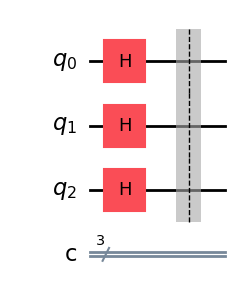

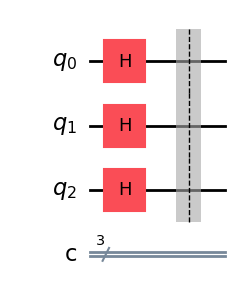

In [4]:

# --- 3. Inicialização para Superposição Uniforme ---
# Aplica uma porta Hadamard (H) a cada qubit.
# Isso coloca todos os qubits em uma superposição uniforme de todos os 2^n estados possíveis.
# Cada estado tem uma amplitude de 1/sqrt(N).
qc.h(range(n_qubits))
qc.barrier() # Barreira para visualização clara no circuito
qc.draw('mpl')


In [5]:

# --- 4. Loop das Iterações do Grover ---
for _ in range(num_iterations): 
    '''
    --- 1. Oráculo (Marca o Estado Desejado) ---
    O oráculo inverte a fase do estado marcado |110⟩
    1. Para cada qubit q_i=0 em |s⟩, aplicamos a porta X (NOT).
        Isso transforma |s⟩ em |11...1⟩ (todos uns).
    2. Aplicamos uma porta multi-controlado Z (MCZ) em todos os qubits.
        A MCZ só inverte a fase se todos os qubits forem 1.
    3. Revertemos q porta X.
    '''
    # Exemplo para |110⟩ (q2=1, q1=1, q0=0):
    if marked_state[2] == '0': # q0
        qc.x(0)
    if marked_state[1] == '0': # q1
        qc.x(1)
    if marked_state[0] == '0': # q2
        qc.x(2)

    '''
    # Aplica uma CCZ (Controlled-Controlled-Z) para 3 qubits.
    # MCZ o memso que é H + MCX + H.
    # A MCX do Qiskit é a porta de Toffoli (CCX) se tiver 2 controles.
    # Para 3 qubits, usamos 2 controles e 1 target para a CCX que simula o MCZ.
    # q0 e q1 são controles e q2 é o target.
    # A barreira antes do CCZ é para a visualização da porta multi-controlada.
    '''
    qc.h(n_qubits - 1) # H no qubit mais significativo (q2)
    # MCX para 3 qubits: q0 e q1 são controles, q2 é o target
    # Isso aplica uma X a q2 se q0 e q1 forem 1.
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1) # Controles: q0, q1. Target: q2.
    qc.h(n_qubits - 1) # H no qubit mais significativo (q2)

    # Reverte os portões X da etapa 1
    if marked_state[2] == '0': # q0
        qc.x(0)
    if marked_state[1] == '0': # q1
        qc.x(1)
    if marked_state[0] == '0': # q2
        qc.x(2)

    qc.barrier()

    ''' 
    2. Operador Difusor (Grover Amplifier)
    Este operador inverte a amplitude dos estados que não são o marcado
    em torno da amplitude média, amplificando a amplitude do estado marcado.
    '''
    qc.h(range(n_qubits)) # Aplica H a todos os qubits.
   
    qc.x(range(n_qubits))  # Aplica X a todos os qubits.

    # 3. Aplica um MCZ que inverte a fase do estado
    # Para 3 qubits, usamos 2 controles (q0, q1) e q2 como target para a CCX.
    qc.h(n_qubits - 1) # H no qubit mais significativo (q2)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1) # CCX(q0, q1, q2)
    qc.h(n_qubits - 1) # H no qubit mais significativo (q2)

    # 4. Reverte as X.
    qc.x(range(n_qubits))
    # 5. Reverte as H.
    qc.h(range(n_qubits))
    qc.barrier()


In [6]:
# --- 5. Medição ---
# Mede todos os qubits quânticos e armazena os resultados nos bits clássicos.
qc.measure(range(n_qubits), range(n_qubits))

Circuito Final do Algoritmo de Grover:


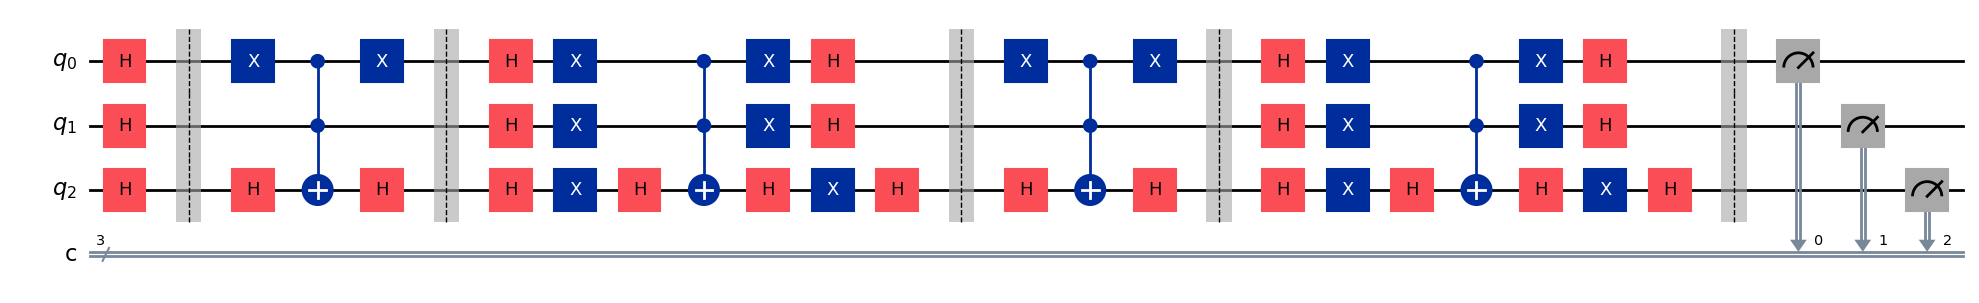

In [7]:
# --- 6. Visualização do Circuito Final ---
print("Circuito Final do Algoritmo de Grover:")
# Desenha o circuito. 'mpl' para visualização em matplotlib.
# 'fold=-1' para evitar que o circuito seja dobrado em múltiplas linhas, mostrando-o completo.
qc.draw('mpl', fold=-1, filename='grover_circuit.png')
plt.show()

In [8]:
# --- 7. Execução no Simulador e Análise de Resultados ---
# Usa o simulador de tiros (shots) do Qiskit Aer
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Executa o circuito no simulador com um grande número de 'shots' (tentativas)
shots = 10000
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts(qc)

print("\nResultados das Medições (Contagens):")
print(counts)


Resultados das Medições (Contagens):
{'101': 78, '001': 76, '110': 9451, '100': 79, '000': 80, '010': 79, '111': 77, '011': 80}


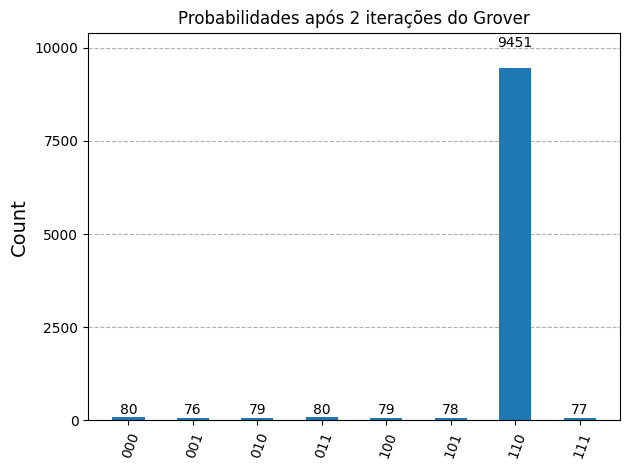

In [9]:
# --- 8. Plotagem das Probabilidades ---
'''
Inverte os nomes dos estados para corresponder à ordem dos qubits (q2 q1 q0 -> 0 1 2)
para que o plot_histogram exiba corretamente.
Qiskit retorna os bits na ordem do mais significativo para o menos significativo.
`plot_histogram` naturalmente mostra da esquerda para a direita como MSB para LSB.
'''
plot_histogram(counts, title=f"Probabilidades após {num_iterations} iterações do Grover")
plt.show()

# Verificação do Statevector (antes da medição)
# Para entender as amplitudes, rodamos o circuito sem medição no statevector_simulator.
# Este passo não faz parte do algoritmo real, foi só para análise.
qc_statevector = QuantumCircuit(n_qubits)
qc_statevector.h(range(n_qubits))


In [10]:

for _ in range(num_iterations):
    # Oráculo (copiado do circuito principal)
    if marked_state[2] == '0': qc_statevector.x(0)
    if marked_state[1] == '0': qc_statevector.x(1)
    if marked_state[0] == '0': qc_statevector.x(2)
    qc_statevector.h(n_qubits - 1)
    qc_statevector.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc_statevector.h(n_qubits - 1)
    if marked_state[2] == '0': qc_statevector.x(0)
    if marked_state[1] == '0': qc_statevector.x(1)
    if marked_state[0] == '0': qc_statevector.x(2)

    # Difusor (copiado do circuito principal)
    qc_statevector.h(range(n_qubits))
    qc_statevector.x(range(n_qubits))
    qc_statevector.h(n_qubits - 1)
    qc_statevector.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc_statevector.h(n_qubits - 1)
    qc_statevector.x(range(n_qubits))
    qc_statevector.h(range(n_qubits))

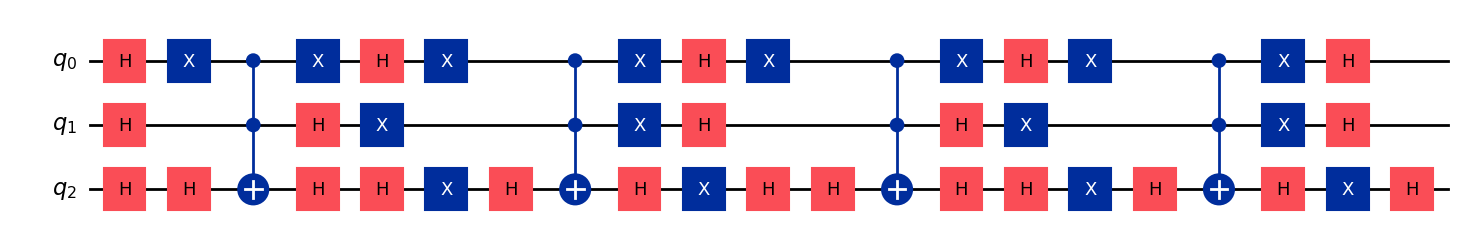

In [11]:
# Visaulização do circuito sem medição
qc_statevector.draw('mpl', fold=-1, filename='grover_statevector_circuit.png')
plt.show()

In [12]:
# Executa no simulador
statevector_simulator = AerSimulator(method='statevector')
job_sv = statevector_simulator.run(qc_statevector)
result_sv = job_sv.result()
statevector = result_sv.get_statevector(qc_statevector)

print("\nStatevector Final (amplitudes):")
print(statevector)

# Calcula as probabilidades a partir do statevector
probabilities = np.abs(statevector)**2

# Cria um dicionário para plotar com nomes de estados
state_names = [format(i, '03b') for i in range(N)] # '03b' para 3 bits binários
prob_dict = {state_names[i]: prob for i, prob in enumerate(probabilities)}

plot_histogram(prob_dict, title="Probabilidades do Statevector antes da Medição")
plt.show()

# Opcional: Visualização do Bloco de Esfera (para 3 qubits é complexo, mas é possível ver)
# plot_bloch_multivector(statevector)
# plt.show()

QiskitError: 'No statevector for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x117833800>"'